# Navier-Stokes 2D: Doubly-periodic shear layer

A 2D NS problem with a doubly-period shear layer initial condition.


** Lattice Boltzmann method **

A simple lattice Boltzmann Bhatnagar-Gross-Krook (LBGK) model is used, given in discrete form as:
\begin{equation}
f_i \left(\mathbf{x} + \mathbf{c}_i, t+1\right) - f_i \left(\mathbf{x}, t\right) = \alpha \beta \left(f_i^{eq} - f_i\right)
\end{equation}

where $\alpha = 2$, $\beta = \left(2\nu/c_s^2 +1 \right)^{-1}$, $f_i$ is the population of discrete velocities $\mathbf{c}_i$ and $f_i^{eq}$ is the equilibrium population. The local macroscopic (i.e. density and momentum) is defined as:

\begin{equation}
\rho = \Sigma_i f_i
\end{equation} 
and
\begin{equation}
\rho \mathbf{u} = \Sigma_i \mathbf{c}_i f_i
\end{equation} 

The present LBM model uses D2Q9 lattice, discretizing the velocity spaces with 9 population function for simulating 2D-dimensional flow. The associated lattice velocites $[c_x, c_y]^T$ and lattice weights $W$ are:

\begin{equation}
\left[\begin{array}{c}
	c_x\\c_y
	\end{array} \right]
	=
	\left[
\begin{array}{ccccccccc}
	0 & 1 & 0 & -1 & 0 & 1 & -1 & -1 & 1\\ 
	0 & 0 & 1 & 0 & -1 & 1 & 1 & -1 & -1\\ 
	\end{array} \right]
\end{equation}
and
\begin{equation}
W = 
\left[
\begin{array}{ccccccccc}
\frac{4}{9} & \frac{1}{9} & \frac{1}{9} & \frac{1}{9}& \frac{1}{9} & \frac{1}{36} & \frac{1}{36}  & \frac{1}{36}  & \frac{1}{36} \\ 
\end{array} \right]
\end{equation}

The equilibrium population $f_i^{eq}$ is determined from local conservations:
\begin{equation}
f_i^{eq} = \rho W_i \left(2 - \sqrt{1 + 3 u_x^2}\right) \left(2 - \sqrt{1 + 3 u_y^2}\right) \\
\left(\frac{2u_x- \sqrt{1 + 3 u_x^2}}{1 - u_x}\right)^{c_{x,i}} \left(\frac{2u_y- \sqrt{1 + 3 u_y^2}}{1 - u_y}\right)^{c_{y,i}}
\end{equation}

The discrete LBM is split into two operations: advection (streaming) and relaxtion (collision) step.


## Import Modules

**Standard**

In [1]:
import time
import numpy as np
import math

**High performance computing**

In [2]:
from numba import vectorize, jit

**Plotting**

In [3]:
import matplotlib.pyplot as plt
import gr
from gr import pygr
gr.inline('svg')

**Lattice boltzmann solver**

In [4]:
import ragnarok

## Initial condition

In [5]:
def doublyperiodicshearlayer():
    delta = 0.05
    kappa = 80.0
    u0 = 0.01
    ux = np.zeros(x.shape)
    ux[y<=Ny/2.0] = u0*np.tanh(kappa*(y[y<=Ny/2.0]/float(Ny) - 0.25))
    ux[y>Ny/2.0]  = u0*np.tanh(kappa*(0.75 - y[y>Ny/2.0]/float(Ny)))
    uy = delta*u0*np.sin(2*np.pi*(x/float(Nx) + 0.25))
    return ux, uy

## Plotting function

**GR version**

In [18]:
def plot(t,zlim=(-0.25,0.25)):
    vortz = curl(solver.u)
    pygr.surface(vortz, rotation=0, tilt=90,colormap=34,
                 xlabel='x', ylabel='y', title='vortz - T = {}'.format(t),
                 zlim=zlim, accelerate=True)

** MPL version:**

In [7]:
def plot_mpl(i):
    plt.figure('plot')
    plt.clf()
    vortz = curl(solver.u)
    levels = np.linspace(-0.25,0.25,26)
    plt.contourf(x,y,vortz,levels,cmap='RdBu_r',extend='both')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('T = %d' % i)
    plt.colorbar(ticks=levels[::5])
    plt.axis('scaled')
    plt.axis([0,Nx,0,Ny])
    plt.pause(0.1)
    

## Post-processing functions

**Velocity norm:**

In [8]:
@vectorize(['float64(float64,float64)'],target='parallel')
def calcnorm(ux,uy):
    return math.sqrt(ux**2+uy**2)

**Velocity curl - vorticity:**

In [9]:
@jit
def curl(u):
    dudx,dudy = np.gradient(u[0], 1.0/Nx,1.0/Ny)
    dvdx,dvdy = np.gradient(u[1], 1.0/Nx,1.0/Ny)
    return dvdx - dudy

## Settings

**Simulation parameters**

In [10]:
Re = 30000 # Reynolds number
T = 20000 # Number of time steps 
U = 0.1 # Lattice velocity

Nx = 100 # Number of lattice in x-dir
Ny = 100 # Number of lattice in y-dir

**Postprocessing parameters**

In [11]:
# Flags
apply_bc = True
plot_step = 100
plot_save = False
plot_flag = True

## Solver

Initialze the 2D NS solver:

In [12]:
solver = ragnarok.NavierStokes2D(U=U, Re=Re, Nx=Nx, Ny=Ny)

nu = 0.000333
beta = 0.998004
omega = 1.996008


Reference parameters:

In [13]:
# Get parameters
L = solver.L
U = solver.U
nu = solver.nu
Nx = solver.Nx
Ny = solver.Ny
cs = solver.cs
x = solver.x[0]
y = solver.x[1]

## Initial conditions

The doubly periodic shear layer (DPSL) describes the case of roll-up of two anti-parallel shear layers within a periodic square domain. The initial condition is given as:

\begin{align}
u_x &= \left\{  \begin{array}{l}
u_0 \tanh \left[\kappa \left(\frac{y}{N} - \frac{1}{4}\right) \right], y \le N/2, \\
u_0 \tanh \left(\kappa \left(\frac{3}{4} - \frac{y}{N}\right) \right), y > N/2, \\
\end{array} \right.\\
\\
u_y &= \delta \sin \left[ 2 \pi  \left(\frac{x}{N} + \frac{1}{4} \right)\right].
\end{align}

**Assign the initial condition:**

In [19]:
# Setup initial conditions (Doubly periodic shear layer)
ux, uy = doublyperiodicshearlayer()

**Initialize the population:**

In [20]:
solver.initialize(ux=ux,uy=uy)

** Plot initial condition **

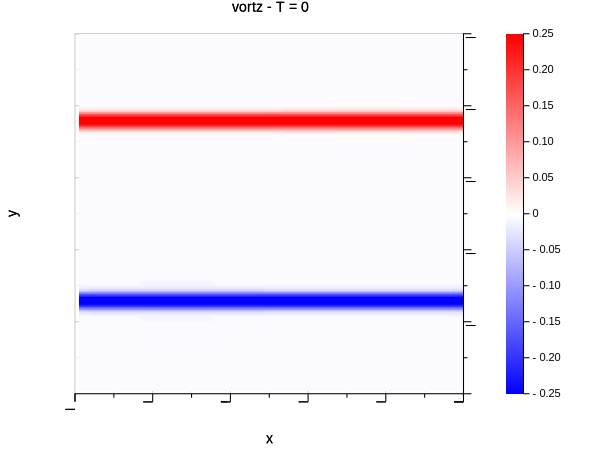

In [21]:
plot(0)

## Time stepping

The simulation parameters are $\mathrm{Re} = (U L)/\nu = 30\ 000$, $\delta = 0.05$, $\kappa = 80$, $L = N = N_x = N_y = 100$ and $U=0.1$, providing a $\beta = 0.9980$. The vorticity of the flow is defined as $\omega = \nabla \times \mathbf{u}$ and in 2D with $\mathbf{u} = (u_x,u_y)^T$, it is given as:
\begin{equation}
\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{equation}

**Simulation Algorithm**:
 1. `stream`: Streaming / advection step: $f'_i(x) \leftarrow f^n_i(x-c_i)$
 2. `apply_periodic`: Apply periodic boundary condition
 3. `relax`: Relaxation / collision step: $f^{n+1}_i(x) \leftarrow f'_i  + \alpha\beta \left[f'^{eq}_i(x,t) - f'_i(x,t)\right]$

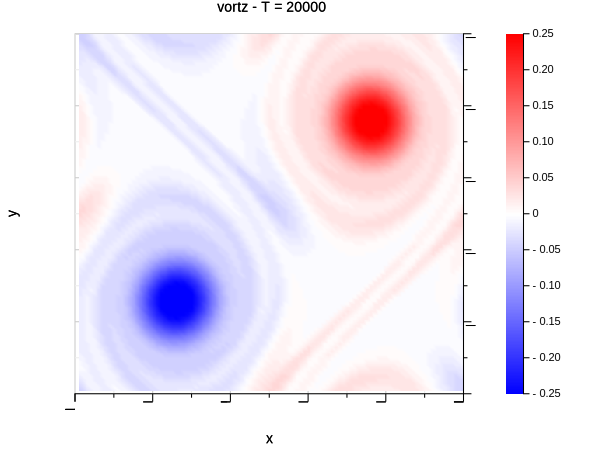

Total time: 24.7124 sec for 20000 steps, 1.23562 ms/step


In [22]:
for t in range(T+1):
    if t==1: # for JIT
        startTime = time.time()
    
    # Plot
    if plot_flag and t % plot_step == 0:
        plot(t)
        if plot_save: plt.savefig('dpsl_t%04d.pdf' % t)

    # Step 1: Streaming / advection step: f'_i(x) <- f^n_i(x-c_i)
    solver.stream()
    
    # Step 2: Apply boundary condition
    solver.apply_periodic()
    
    # Step 3: Relaxation / collision step: f^{n+1}_i(x) <- f'_i + \alpha\beta [f^{eq}'_i(x,t) - f'_i(x,t)]
    solver.relax()
    
    if solver.rho.min() <= 0.:
        print('Density is negative!')
        break

# Done
duration = time.time()-startTime
print('Total time: {:3g} sec for {:d} steps, {:3g} ms/step'.format(duration, T, duration/T*1000))        